In [156]:
# This cell is from the template notebook. It contains ipython magic and 
# various useful imports which are commonly used in this app.

%load_ext autoreload
%autoreload 2

import pandas as pd
import datetime
import numpy as np
import os
from acoustic_data_science import config, helpers, analysis
#import acoustic_data_science.analysis.transient_durations as transient_durations
import acoustic_data_science
import matplotlib.pyplot as plt
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- Data is loudness against time with loudness in each TOL.
- Want to see transients labelled as such.
- Want to know the duration of each transient.
- Want to retain its frequency information, perhaps even the full spectrogram.

Ideal final data structure:
- Dataframe which contains the timestamp at which each transient starts and its duration.
- Can use this timestamp & duration to further investigate the transient e.g. lookup its spectrogram.

#   Get transient durations with timestamps

In [17]:
df = pd.read_feather(helpers.feather_path_from_month_name(config.processed_data_path, '2018_09'), columns=['timestamp', 'loud'])

df = df[df["loud"]]
df

,timestamp,loud
123,2018-09-01 00:11:03.000,True
421,2018-09-01 00:13:32.000,True
429,2018-09-01 00:13:36.000,True
430,2018-09-01 00:13:36.500,True
433,2018-09-01 00:13:38.000,True
...,...,...
3634595,2018-09-30 21:45:59.000,True
3634596,2018-09-30 21:45:59.500,True
3634608,2018-09-30 21:46:05.500,True
3634609,2018-09-30 21:46:06.000,True


In [18]:
df["increasing_count"] = np.arange(df.shape[0])
df["transient_group"] = df.index - df["increasing_count"]
df["duration"] = np.full(len(df), 0.5)
df.head(50)

,timestamp,loud,increasing_count,transient_group,duration
123,2018-09-01 00:11:03.000,True,0,123,0.5
421,2018-09-01 00:13:32.000,True,1,420,0.5
429,2018-09-01 00:13:36.000,True,2,427,0.5
430,2018-09-01 00:13:36.500,True,3,427,0.5
433,2018-09-01 00:13:38.000,True,4,429,0.5
434,2018-09-01 00:13:38.500,True,5,429,0.5
435,2018-09-01 00:13:39.000,True,6,429,0.5
436,2018-09-01 00:13:39.500,True,7,429,0.5
437,2018-09-01 00:13:40.000,True,8,429,0.5
438,2018-09-01 00:13:40.500,True,9,429,0.5


In [19]:
transient_durations_series = df.groupby(['transient_group'])['duration'].sum()
# Starting index of transients gets lost when grouping.
# Recover by taking cumulative sum of the durations and divide by the duration length (0.5 s) to get the number of skipped rows.
transient_durations_df_index = (transient_durations_series.index + transient_durations_series.cumsum(axis=0)/0.5 - np.ones(len(transient_durations_series))).astype('int').values

transient_durations_df = pd.DataFrame({'transient_group':transient_durations_df_index, 'duration':transient_durations_series.values})
transient_durations_df

,transient_group,duration
0,123,0.5
1,421,0.5
2,430,1.0
3,462,15.0
4,465,1.0
...,...,...
5250,3634590,1.0
5251,3634593,1.0
5252,3634596,1.0
5253,3634609,1.0


In [20]:
transient_durations_df["timestamp"] = df[df.index.isin(transient_durations_df["transient_group"])]['timestamp'].values
df[df.index.isin(transient_durations_df["transient_group"])]['timestamp']
transient_durations_df.head(50)

,transient_group,duration,timestamp
0,123,0.5,2018-09-01 00:11:03.000
1,421,0.5,2018-09-01 00:13:32.000
2,430,1.0,2018-09-01 00:13:36.500
3,462,15.0,2018-09-01 00:13:52.500
4,465,1.0,2018-09-01 00:13:54.000
5,711,0.5,2018-09-01 00:15:57.000
6,990,0.5,2018-09-01 00:18:17.000
7,1373,0.5,2018-09-01 00:21:29.000
8,1496,4.5,2018-09-01 00:22:30.500
9,1652,0.5,2018-09-01 00:23:48.500


#   Extend to whole year

In [21]:
"""
# OLD, see new func below
def get_transient_timestamps_and_durations(df):
    # Just get the loud events.
    df = df[df["loud"]]

    # Each transient has a number called transient_group.
    # Half-seconds in the same transient have the same transient_group.
    df["transient_group"] = df.index - np.arange(df.shape[0])

    # Recover the original index lost by grouping.
    # =========================================================================
    df["duration"] = np.full(len(df), 0.5).tolist()
    
    transients_series = df.groupby(['transient_group'])['duration'].sum()
    # Starting index of transients gets lost when grouping.
    # Recover by taking cumulative sum of the durations and divide by the duration length (0.5 s) to get the number of skipped rows.
    transients_df_index = (transients_series.index + transients_series.cumsum(axis=0)/0.5 - np.ones(len(transients_series))).astype('int').values
    # =========================================================================

    transients_df = pd.DataFrame({'transient_group':transients_df_index, 'duration':transients_series.values})

    transients_df["timestamp"] = df[df.index.isin(transients_df["transient_group"])]['timestamp'].values
    transients_df[:, '25':'25119'] = df[df.index.isin(transients_df["transient_group"])].loc[:, '25':'25119']

    #transients_df.drop(columns=['transient_group'], inplace=True)

    return transients_df
"""

'\n# OLD, see new func below\ndef get_transient_timestamps_and_durations(df):\n    # Just get the loud events.\n    df = df[df["loud"]]\n\n    # Each transient has a number called transient_group.\n    # Half-seconds in the same transient have the same transient_group.\n    df["transient_group"] = df.index - np.arange(df.shape[0])\n\n    # Recover the original index lost by grouping.\n    # =========================================================================\n    df["duration"] = np.full(len(df), 0.5).tolist()\n    \n    transients_series = df.groupby([\'transient_group\'])[\'duration\'].sum()\n    # Starting index of transients gets lost when grouping.\n    #\xa0Recover by taking cumulative sum of the durations and divide by the duration length (0.5 s) to get the number of skipped rows.\n    transients_df_index = (transients_series.index + transients_series.cumsum(axis=0)/0.5 - np.ones(len(transients_series))).astype(\'int\').values\n    # ========================================

In [157]:
def get_transients(df, average_tols=False):
    # Just get the loud events.
    df = df[df["loud"]]

    # Each transient has a number called transient_group.
    # Half-seconds in the same transient have the same transient_group.
    df.loc[:, "transient_group"] = df.index - np.arange(df.shape[0])
    # Recover the original index lost by grouping.
    # =========================================================================
    df.loc[:, "duration"] = np.full(len(df), 0.5).tolist()
    transient_groups_summed = df.groupby(['transient_group']).sum()
    durations = transient_groups_summed["duration"]

    # Starting index of transients gets lost when grouping.
    # Recover by taking cumulative sum of the durations and divide by the duration length (0.5 s) to get the number of skipped rows.
    durations_index = (durations.index + durations.cumsum(axis=0)/0.5 - np.ones(len(durations))).astype('int').values
    # =========================================================================

    transients_df = df[df.index.isin(durations_index)]
    transients_df.loc[:, "duration"] = durations.values
    transients_df.drop(columns=['transient_group'], inplace=True)

    transients_df = transients_df.reset_index(drop=True)

    if average_tols:
        transients_df.loc[:, "25":"25119"] = transients_df.loc[:, "25":"25119"]#.div(transients_df["duration"]/0.5, axis=0)
    
    return transients_df

In [152]:
monthly_feather_paths = helpers.get_feather_paths(config.processed_data_path + '/monthly_data')
month_names = helpers.get_month_names(config.processed_data_path + '/monthly_data')
for monthly_feather_path, month_name in zip(monthly_feather_paths, month_names):
    df = pd.read_feather(monthly_feather_path).drop(columns=['unnormalised_broadband_spl', "short_transient"])
    transients_df = get_transients(df, average_tols=True)
    transients_df.to_feather(os.path.join(config.processed_data_path,f'transients/{month_name}.feather'))


/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is tryi

In [162]:
df = pd.read_feather(os.path.join(config.processed_data_path,f'transients/2019_01.feather'))
#df = get_transients(df, average_tols=True)
df[df["duration"] > 10]


,25,32,40,50,63,79,100,126,158,200,...,12589,15849,19953,25119,filename,timestamp,broadband_spl,background_spl,loud,duration
1,65.965736,73.088669,72.841736,65.948158,68.266792,76.444908,71.953476,75.669411,79.316467,79.937920,...,64.662582,64.590828,63.952419,60.401340,ICLISTENHF1266_20190101T001602.996Z_TOL_1sHann...,2019-01-01 00:19:55.996,-51.626615,-67.731734,True,21.0
7,64.272163,68.120018,72.505760,65.887161,67.736397,83.705231,86.238594,69.174835,76.219467,79.901375,...,58.035511,58.547146,60.589542,57.260994,ICLISTENHF1266_20190101T002602.996Z_TOL_1sHann...,2019-01-01 00:26:54.996,-55.869226,-66.284618,True,36.0
99,65.056564,70.217987,68.725670,66.817940,66.296181,84.774399,77.347198,75.350243,79.108154,71.632133,...,61.275948,61.652485,62.034519,58.783207,ICLISTENHF1266_20190101T005602.996Z_TOL_1sHann...,2019-01-01 00:57:05.496,-55.564392,-65.612762,True,70.0
100,63.552525,70.600655,70.622238,70.052254,63.037357,72.986794,71.069595,95.374107,86.225449,83.356743,...,59.461029,59.356895,60.708855,57.766525,ICLISTENHF1266_20190101T005602.996Z_TOL_1sHann...,2019-01-01 00:58:48.496,-50.416718,-62.697411,True,62.5
203,62.137985,72.746933,69.117325,66.966827,64.125496,77.726028,64.239487,71.390976,70.033623,78.670776,...,58.245472,58.878914,60.364796,57.421413,ICLISTENHF1266_20190101T023804.000Z_TOL_1sHann...,2019-01-01 02:40:50.000,-55.869211,-66.701975,True,31.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57262,77.525803,74.908745,73.244415,71.651253,79.786713,87.720619,86.462494,90.078316,89.986626,100.210953,...,67.978264,67.882149,67.187553,63.419727,ICLISTENHF1266_20190131T210348.959Z_TOL_1sHann...,2019-01-31 21:04:50.459,-44.955117,-58.652621,True,19.0
57273,67.737831,72.489662,72.767456,71.235741,72.249352,85.403214,76.119713,74.128448,77.678169,82.586174,...,66.624886,65.137428,63.868332,59.988747,ICLISTENHF1266_20190131T224033.007Z_TOL_1sHann...,2019-01-31 22:42:30.507,-48.856713,-60.454299,True,18.5
57274,65.406281,72.380905,75.035446,75.743240,74.317291,86.762535,87.507736,86.517807,84.448357,84.944351,...,60.916832,60.348534,61.373882,58.817944,ICLISTENHF1266_20190131T224532.996Z_TOL_1sHann...,2019-01-31 22:45:59.496,-49.908948,-60.008844,True,14.5
57291,71.057068,72.510468,70.511902,74.698387,72.268295,87.683449,83.340141,85.662300,91.909828,92.914787,...,75.686050,74.472038,72.693909,68.495758,ICLISTENHF1266_20190131T230402.996Z_TOL_1sHann...,2019-01-31 23:06:56.996,-44.125813,-59.353903,True,13.0


In [25]:
whole_year_df = pd.read_feather(config.processed_data_path + '/whole_year/whole_year.feather')
whole_year_df["loud"] = whole_year_df["broadband_spl"] > whole_year_df["background_spl"] + 10
whole_year_transients_df = get_transients(whole_year_df)
whole_year_transients_df = whole_year_transients_df.drop(columns=["loud"])
whole_year_transients_df.to_feather(config.processed_data_path + '/transients/whole_year_transients_and_durations.feather')
whole_year_transients_df

/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is tryi

,timestamp,broadband_spl,background_spl,duration
0,2018-08-02 00:23:09.500,-48.511243,-59.933503,0.5
1,2018-08-02 00:23:10.500,-44.798160,-59.914447,0.5
2,2018-08-02 00:23:11.500,-49.693166,-59.900054,0.5
3,2018-08-02 00:23:13.000,-48.039116,-59.874419,1.0
4,2018-08-02 00:25:16.500,-44.149546,-54.485586,121.5
...,...,...,...,...
412305,2019-05-31 22:51:03.855,-43.255208,-64.609792,0.5
412306,2019-05-31 22:53:22.507,-52.194121,-64.656006,0.5
412307,2019-05-31 22:56:58.507,-52.946478,-64.694019,2.0
412308,2019-05-31 22:57:27.507,-48.559140,-63.667097,28.5


#   Plotting

In [59]:
def plot_transients(df, min_duration=None, max_duration=None, title=""):
    if min_duration is not None:
        df = df[df["duration"] >= min_duration]

    if max_duration is not None:
        df = df[df["duration"] <= max_duration]

    # Floor timestamp column to the day to get YYYY-MM-DD
    days = df['timestamp'].dt.floor('D')
    transients_per_day = df.groupby(days).size()
    # Day.
    x = transients_per_day.index
    # Number of transients per day.
    y = transients_per_day.values

    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.scatter(x, y)
    plt.show()

print(whole_year_transients_df["duration"].max())

452.5


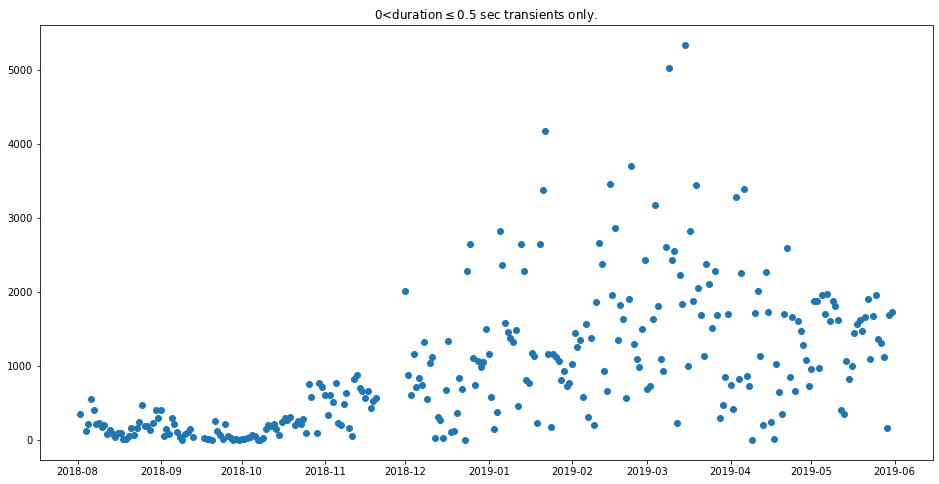

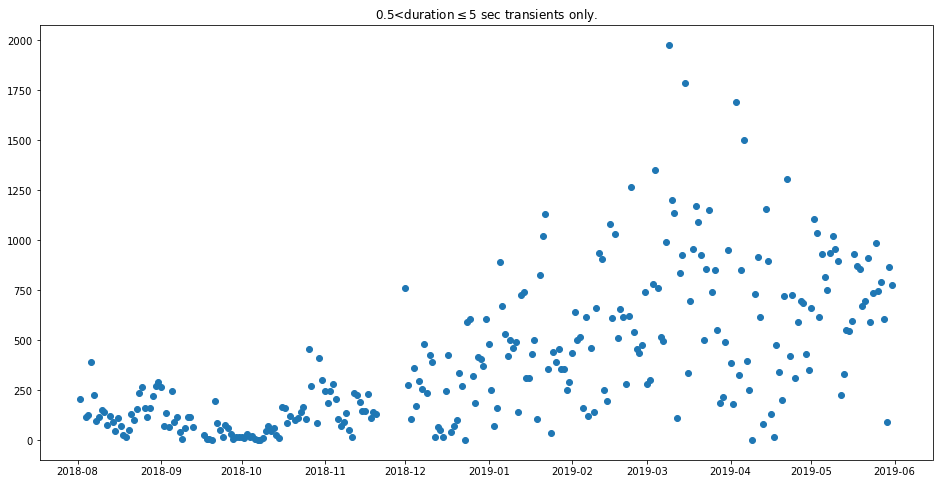

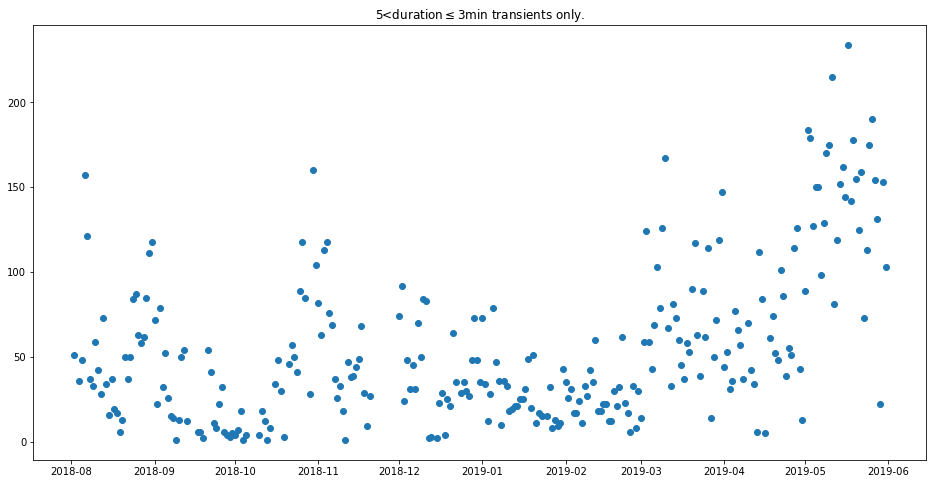

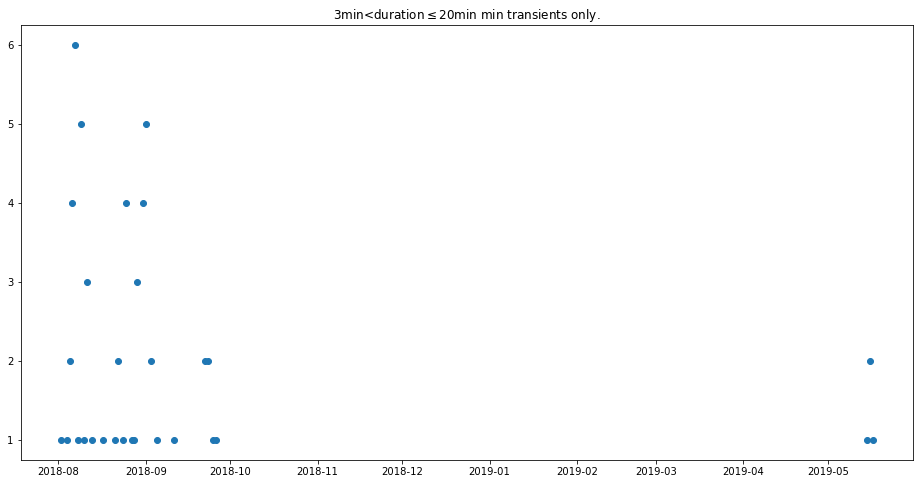

In [60]:
plot_transients(whole_year_transients_df, min_duration=0, max_duration=0.5, title=r"$0 \less \rm{duration} \leq 0.5$ sec transients only.")
plot_transients(whole_year_transients_df, min_duration=0.5+0.5, max_duration=5, title=r"$0.5 \less \rm{duration} \leq 5$ sec transients only.")
plot_transients(whole_year_transients_df, min_duration=5+0.5, max_duration=3*60, title=r"$5 \less \rm{duration} \leq 3 \rm{min}$ transients only.")
plot_transients(whole_year_transients_df, min_duration=3*60+0.5, max_duration=20*60, title=r"$3 \rm{min} \less \rm{duration} \leq 20 min$ min transients only.")

#   Compare to old code which gets durations without any other info.

In [34]:
df = pd.read_feather(config.processed_data_path + "/whole_year/whole_year.feather")
df["loud"] = df["broadband_spl"] > df["background_spl"] + 20
print(len(df))

# Old func.
def get_transient_durations(df):
    df = df[df["loud"]]

    # Mask df to only get loud rows.
    df['transient_group'] = (df.index - np.arange(df.shape[0]))
    index_groups = df['transient_group'].unique()
    
    transient_durations = []
    for index_group in index_groups:
        transient_times = df[df['transient_group']==index_group]['timestamp'].values
        transient_durations.append((transient_times[-1] - transient_times[0]).astype('float')/1e9 + 0.5)
    
    # Cull any detected transient with length longer than 5 mins. Arbitrary for now.
    #transient_durations[i] = transient_durations[transient_durations < 5*60]
    transient_durations = np.array(transient_durations)
    return transient_durations

transient_durations = get_transient_durations(df)
transient_durations.max()

30048625


/var/folders/xw/j5fzsq4j5d5gfqy4tsdkbz0h0000gn/T/ipykernel_35423/2746565188.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transient_group'] = (df.index - np.arange(df.shape[0]))


3118.5

#   Plot all durations on one plot with colour coding.

In [73]:
def plot_all_transient_durations(df, title=""):
    # Floor timestamp column to the day to get YYYY-MM-DD
    days = df['timestamp'].dt.floor('D')
    #transients_per_day = df.groupby(days).size()
    transients_per_day = df.groupby("duration").size()
    '''
    #colours = transients_per_day['duration']
    # Day.
    x = transients_per_day.index
    # Number of transients per day.
    y = transients_per_day.values

    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.scatter(x, y)#, c=colours)
    plt.show()
    '''
    return transients_per_day


print(whole_year_transients_df["duration"].max())

plot_all_transient_durations(whole_year_transients_df, title="Number of transients per day colour coded by duration")

452.5


duration
0.5      279833
1.0       74248
1.5       19742
2.0        8721
2.5        4804
          ...  
331.0         1
348.5         1
389.0         1
420.0         1
452.5         1
Length: 367, dtype: int64

# Fitting duration occurance

Trying to fit the decrease of transient occurance with increasing duration to some common function e.g. occurance ~ e^-(duration) or occurance ~ 1/(duration) but failed. Most similar to an exponential.

In [83]:
transients_by_duration = whole_year_transients_df.groupby("duration").size()
transients_by_duration = transients_by_duration[transients_by_duration.values>100]
transients_by_duration

duration
0.5     279833
1.0      74248
1.5      19742
2.0       8721
2.5       4804
3.0       3090
3.5       2258
4.0       1750
4.5       1346
5.0       1121
5.5        964
6.0        840
6.5        703
7.0        685
7.5        589
8.0        525
8.5        507
9.0        443
9.5        452
10.0       451
10.5       360
11.0       374
11.5       342
12.0       342
12.5       272
13.0       279
13.5       275
14.0       278
14.5       240
15.0       226
15.5       217
16.0       202
16.5       215
17.0       199
17.5       175
18.0       174
18.5       176
19.0       172
19.5       157
20.0       170
20.5       141
21.0       132
21.5       109
22.0       132
22.5       125
23.0       107
23.5       114
24.0       120
24.5       129
25.0       106
25.5       102
dtype: int64

<BarContainer object of 51 artists>

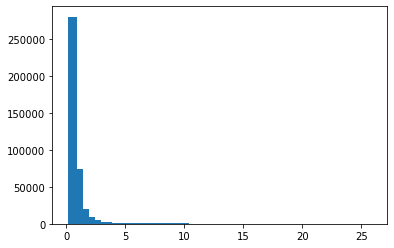

In [99]:
x_data = transients_by_duration.index
y_data = transients_by_duration.values

plt.bar(x, y_data, label="data")

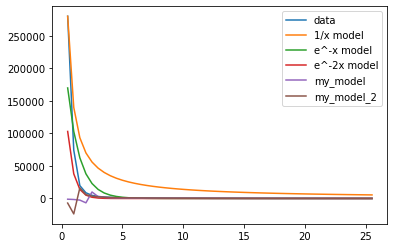

In [137]:
x_data = transients_by_duration.index
y_data = transients_by_duration.values

plt.plot(x_data, y_data, label="data")

plt.plot(x_data, y_data[0]*0.5/x, label="1/x model")
plt.plot(x_data, y_data[0]*np.exp(-x_data), label="e^-x model")
plt.plot(x_data, y_data[0]*np.exp(-2*x_data), label="e^-2x model")

'''
y_model = np.poly1d(np.polyfit(x_data, y_data, 8))
print(y_model)
plt.plot(x_data, y_model(x_data))
'''

my_model = 2000/(-2.3 + x_data)
plt.plot(x_data, my_model, label="my_model")

my_model_2 = 126028/((x_data - 1.20601)*(x_data + 24.82))
plt.plot(x_data, my_model_2, label="my_model_2")

plt.legend()

[ 7.93475938e-06  1.87371650e-04 -2.37513790e-04]


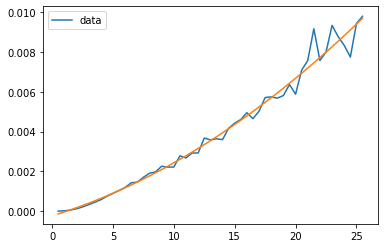

In [133]:
x_data = transients_by_duration.index
y_data = 1/transients_by_duration.values

plt.plot(x_data, y_data, label="data")

#plt.plot(x_data, y_data[0]*0.5/x, label="e^-x model")
#plt.plot(x_data, y_data[0]*np.exp(-x_data), label="1/x model")

coeffs = np.polyfit(x_data, y_data, 2)
print(coeffs)
y_model = np.poly1d(coeffs)
plt.plot(x_data, y_model(x_data))
#plt.plot(x_data, 0.00039368*x_data)

plt.legend()

wolfram alpha:
1/(7.93475938e-06x^2 + 1.87371650e-04x -2.37513790e-04)
126028./((x - 1.20601) (x + 24.82)) (for x!=-24.82 and x!=1.20601)

#   Linearise

           4            3          2
0.0001537 x - 0.009425 x + 0.2042 x - 1.93 x + 12.65


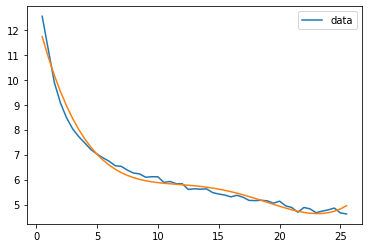

In [144]:
x_data = transients_by_duration.index
y_data = np.log(transients_by_duration.values)

plt.plot(x_data, y_data, label="data")


log_y_model = np.poly1d(np.polyfit(x_data, y_data, 4))
print(y_model)
plt.plot(x_data, log_y_model(x_data))

plt.legend()

Apply results to non-linear.

[1.00015375e+00 9.90619660e-01 1.22657364e+00 1.45126660e-01
 3.10219461e+05]


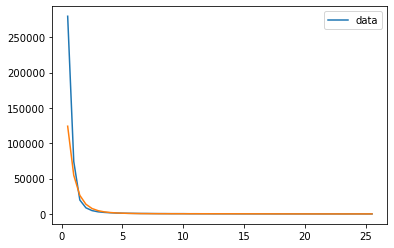

In [148]:
x_data = transients_by_duration.index
y_data = transients_by_duration.values

plt.plot(x_data, y_data, label="data")

y_model_data = np.exp(log_y_model(x_data))
print(y_model)
plt.plot(x_data, y_model_data)

plt.legend()

Result:

e^(310219. + 0.145127 x + 1.22657 x^2 + 0.99062 x^3 + 1.00015 x^4)

e^(310000. + 0.15 x + 1.2 x^2 + x^3 + x^4)

A